## **ENTITY VALUE EXTRACTION**

### 0. SETTING UP

In [34]:
import os
import cv2
import traceback
from constants import unit_variations, entity_unit_map

In [35]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('paddleocr').setLevel(logging.WARNING)

In [36]:
# DATABASE LOCATION
dataset_path = "data/"

train_path = dataset_path + "train.csv"
test_path = dataset_path + "test.csv"
sample_test_path = dataset_path + "sample_test.csv"

In [37]:
# test if paths exist
import os

for path in [train_path, test_path, sample_test_path]:
    if not os.path.exists(path):
        print(f"Missing CSV File: {path}")

Missing CSV File: data/sample_test.csv


### 1. HELPER FUNCTIONS

In [38]:
def display_image(image):
    plt.figure(figsize = (10, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [39]:
def find_all_indices(s, substring):
    pattern = re.compile(re.escape(substring))
    matches = pattern.finditer(s)
    return [match.start() for match in matches]

In [40]:
def is_valid_representation(x):
    for u in unit_variations:
        for r in unit_variations[u]:
            if x.lower() == r.lower():
                return True

In [41]:
from IPython.display import HTML, display

In [42]:
def make_clickable_path(path):
    if os.path.exists(path):
        return f'<a href="{path}" target="_blank">{path}</a>'
    else:
        return f'Path does not exist: {path}'

def display_path(path):
    display(HTML(make_clickable_path(path)))

In [43]:
def extract_weights_with_units(weight_list):
    extracted_weights = []
    for weight in weight_list:
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", weight)
        unit = re.search(r"[a-zA-Z]+", weight)
        
        if unit:
            unit = unit.group()
            for num in nums:
                extracted_weights.append(f"{num} {unit}")
    
    return extracted_weights

### 2. TRAINING

In [44]:
import re
from PIL import Image
import matplotlib.pyplot as plt

from paddleocr import PaddleOCR, draw_ocr

from constants import unit_variations, entity_unit_map

In [45]:
from ppocr.utils.logging import get_logger
import logging
logger = get_logger()
logger.setLevel(logging.ERROR)

In [46]:
image_path = dataset_path + "special_images/image_2.jpg"
image_entity = "item_weight"
font_path = "fonts/latin.ttf"

#### (i) PREPROCESSING

In [47]:
image = cv2.imread(image_path)

In [48]:
def preprocess_image(image_in):
    image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
    # image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
    """
    pre process some tings
    """

    return image_out

In [49]:
image = preprocess_image(image)

Preprocessed Image


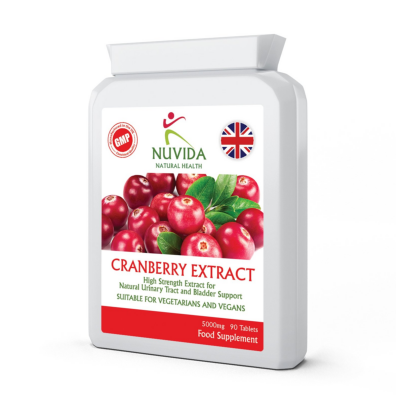

In [50]:
print("Preprocessed Image")
display_image(image)

#### (ii) TEXT RECOGNITION

In [51]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

In [52]:
def get_ocr(image_array):
    return ocr.ocr(image_array)

In [53]:
def show_ocr(image_in, result):
    boxes = [item[0] for item in result[0]]
    texts = [item[1][0] for item in result[0]]
    scores = [item[1][1] for item in result[0]]

    im_show = draw_ocr(image_in, boxes, texts, scores, font_path="fonts/latin.ttf")
    display_image(im_show)

In [54]:
result = ocr.ocr(image)

OCR Output:


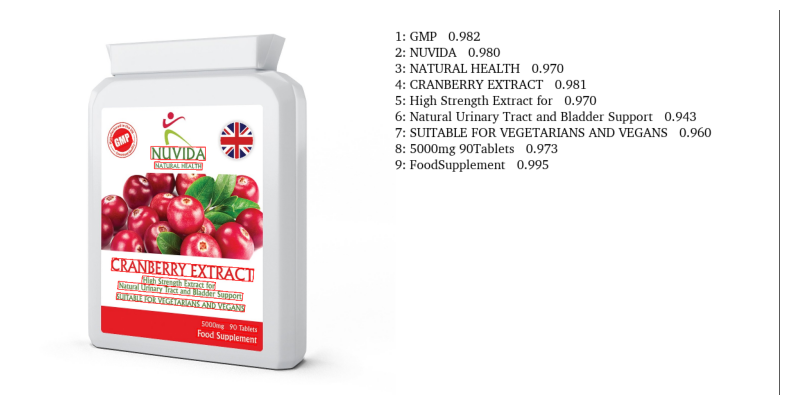

In [55]:
print("OCR Output:")
show_ocr(image, result)

#### (iii) POST PROCESSING

In [56]:
def extract(result_in, entity_name):
    extracted_measurements = []
    extracted_positions = []

    if result_in == [None]:
        return []

    for r in result_in[0]:
        location, line = r
        text = line[0]

        for unit in entity_unit_map[entity_name]:
            for rep in unit_variations[unit]:
                indices = find_all_indices(text.lower(), rep.lower())

                for index in indices:
                    if index <= 0:
                        continue
                    
                    next_rep = text[index: index + 2].lower().strip()
                    if rep.lower() == 'm' and (next_rep != 'm') and is_valid_representation(next_rep):
                        continue
                    
                    if rep.lower() == 'g' and next_rep != 'g':
                        continue

                    numbers = [""]
                    reformat = text[:index].replace(' ', '')

                    i = len(reformat) - 1

                    while (i >= 0) and (reformat[i].isnumeric() or reformat[i] in ['-', '.', 'I', ',']):
                        char = reformat[i]

                        if i == 0 and char == "I":
                            chat = '1'

                        if char.isnumeric() or char == ",":
                            numbers[-1] = char + numbers[-1]
                        elif char in ['.']:
                            numbers[-1] = '.' + numbers[-1]
                        elif char in ['-']:
                            numbers.append("")

                        i -= 1

                    discard_rule = lambda x: len(x.strip().replace('.', '')) > 0
                    numbers = filter(discard_rule, numbers)

                    numbers = map(lambda x: re.sub(r"\.{2,}", "", x), numbers) # *..*
                    numbers = map(lambda x: re.sub(r"\,{2,}", "", x), numbers) # *,,*
                    numbers = map(lambda x: re.sub(r"\-{2,}", "", x), numbers) # *--*

                    numbers = list(numbers)

                    # more than one point
                    # keep right most val
                    for i, num in enumerate(numbers):
                        dot_counts = num.count('.')

                        if dot_counts > 1:
                            dot_split = num.split('.')
                            new_num = '.'.join(dot_split[-2:])
                            numbers[i] = new_num

                        elif dot_counts == 1 and len(num) >= 2:
                            if num[0] == '.':
                                numbers[i] = num[1:]
                    
                    # try to understand europeans
                    for i, num in enumerate(numbers):
                        num = num.lstrip(',')

                        # segregating comma
                        pattern = r'(\d+),(\d{3,})'
                        num = re.sub(pattern, r'\1\2', num)

                        # point comma
                        pattern = r'(\d+),(\d{1,2})'
                        num = re.sub(pattern, r'\1.\2', num)
                        
                        numbers[i] = num

                    discard_rule = lambda x: len(x.strip().replace('.', '')) > 0
                    numbers = filter(discard_rule, numbers)

                    numbers = sorted(list(map(lambda x: float(x), numbers)))

                    if len(numbers) == 0:
                        continue
                    
                    left_most_point = float("inf")
                    right_most_point = 0
                    bottom_most_point = float("inf")
                    top_most_point = 0

                    for point in location:
                        left_most_point = min(left_most_point, point[0])
                        right_most_point = max(right_most_point, point[0])
                        bottom_most_point = min(bottom_most_point, point[1])
                        top_most_point = max(top_most_point, point[1])

                    measurement = f"[{numbers[0]}, {numbers[1]}] {unit}" if len(numbers) > 1 else f"{numbers[0]} {unit}"
                    extracted_measurements.append(measurement)
                    extracted_positions.append([measurement, left_most_point, right_most_point, bottom_most_point, top_most_point])

    return extracted_measurements, extracted_positions

In [57]:
extract(result, image_entity)

(['5000.0 milligram'], [['5000.0 milligram', 761.0, 990.0, 1236.0, 1291.0]])

### 3. NAIVE ITERATION

In [58]:
import pandas as pd
from IPython.display import clear_output

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [59]:
def debug_output(original_image, ocr_result, image_path, e_name, e_value, p_list, p_value):
    display_path(image_path)

    if ocr_result != [None]:
        show_ocr(original_image, ocr_result)

    print("entity name:", e_name)
    print("expected value:", e_value)
    print("predicted list:", p_list)
    print("prediction value:", p_value)

In [60]:
net_weight_pattern = re.compile(r'(net weight|net wt|n\. wt|n\.w\.?)\s*[:\-]?\s*(\d+\.?\d*)', re.IGNORECASE)

def process_row(index, row, image_folder_in):
    if not row["downloaded"]:
        return

    image_name = os.path.basename(row["image_link"])
    image_path = image_folder_in + image_name

    entity_name = row["entity_name"]

    if "entity_value" in df.columns:
        entity_value = row["entity_value"]
    else:
        entity_value = "undefined"

    default_prediction = ""
    current_index = row["index"] if "index" in df.columns else index

    predictions = "ERROR"
    pred_value = "ERROR"

    try:
        original_image = cv2.imread(image_path)
        image_array = preprocess_image(original_image)
        ocr_result = get_ocr(image_array)

        predictions, positions = extract(ocr_result, entity_name)

        # height and width exist in different parts of image
        if entity_name == 'height' or entity_name == 'width':
            global_leftmost = float('inf')
            global_rightmost = 0
            global_bottommost = float('inf')
            global_topmost = 0
            dist_from_wall = []
            dist_from_middle = []
            
            img_height, img_width, _ = image_array.shape

            for position in positions:
                global_leftmost = min(global_leftmost, position[1])
                global_rightmost = max(global_rightmost, position[2])
                global_bottommost = min(global_bottommost, position[3])
                global_topmost = max(global_topmost, position[4])
                
                dist_from_wall.append([position[0], min(abs(0 - (position[1] + position[2]) / 2), img_width - (position[1] + position[2]) / 2)])
                
            middle = (global_leftmost + global_rightmost) / 2

            for position in positions:
                dist_from_middle.append([position[0], abs(middle - (position[1] + position[2]) / 2)])
                
            if entity_name == "height":
                predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key=lambda x: x[1])))
                if len(predictions) > 1:
                    num_0, unit_0 = predictions[0][:predictions[0].rfind(' ')], predictions[0][predictions[0].rfind(' ') + 1:]
                    num_1, unit_1 = predictions[1][:predictions[1].rfind(' ')], predictions[1][predictions[1].rfind(' ') + 1:]
                    
                    try:
                        if float(num_1) > float(num_0):
                            predictions[0], predictions[1] = predictions[1], predictions[0]
                    except Exception as e:
                        pass
            else:
                if len(predictions) == 2:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key=lambda x: -x[1])))
                else:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_middle, key=lambda x: x[1])))

        elif entity_name == "maximum_weight_recommendation":
            try:
                predictions = extract_weights_with_units(predictions)
                predictions = sorted(predictions,key = lambda x : -float(x.split()[0])/2.2 if x.split()[1] == 'pound' else x.split()[0])
                    
            except:
                pass

        elif entity_name == "item_weight":
            for item in result[0]:
                flag = False
                yes = net_weight_pattern.search(item[1][0])
                if yes:
                    num = yes.group(2)
                    for i in predictions:
                        if num in i:
                            pred_value = i
                            flag = True
                            break
                if flag:
                    break          
        # 50mm >> 50m
        # if predictions[0].find("metre") != -1 and predictions[1].find("metre") != -1:
            # num_0, unit_0 = None, None
            # num_1, unit_1 = None, None

            # # which one has mm?
            # p0, p1 = predictions[0].find("millimetre"), predictions[1].find("millimetre")

            # if p0 != p1:
            #     if (p0 != -1):
            #         num_0, unit_0 = predictions[0][:p0], "millimetre"
            #         num_1, unit_1 = predictions[1][:p1], "metre"
            #     elif (p1 != -1):
            #         num_0, unit_0 = predictions[1][:p1], "millimetre"
            #         num_1, unit_1 = predictions[0][:p1], "metre"
                
            #     if num_0 == num_1:
            #         predictions[0], predictions[1], = predictions[1], predictions[0]

        if pred_value == "ERROR":
            pred_value = list(predictions)[0] if len(predictions) > 0 else ""

        if (entity_value != "undefined") and (pred_value.strip() != entity_value.strip()):
            raise ValueError("Incorrect Answer")

        output_row = {"index": current_index, "image_link": row["image_link"], "prediction": pred_value}

    except Exception as e:
        output_row = {"index": current_index, "image_link": row["image_link"], "prediction": pred_value}

        if PAUSE_ON_ERROR:
            print("error:", e)
            traceback.print_exc()
            debug_output(original_image, ocr_result, image_path, entity_name, entity_value, predictions, pred_value)
            choice = input("continue [y]: ")
            if len(choice.strip()) > 0:
                return "stop"

    if PAUSE_ALWAYS:
        debug_output(original_image, ocr_result, image_path, entity_name, entity_value, predictions, pred_value)
        choice = input("continue [y]: ")
        if len(choice.strip()) > 0:
            return "stop"

    if PAUSE_ON_ERROR:
        clear_output(wait = True)

    return output_row

In [61]:
DATASET = "test"
PAUSE_ON_ERROR = False
MULTI_THREADED = False
MAX_THREADS = 3

PAUSE_ALWAYS = False

if MULTI_THREADED:
    PAUSE_ON_ERROR = False

In [62]:
image_folder = f"data/{DATASET}_images/"
df_path = f"data/downloaded_{DATASET}.csv"
output_path = f"data/{DATASET}_output.csv"

df = pd.read_csv(df_path)
output_array = []

# df = df.loc[df["index"].isin(gcc[130163])]
# df = df.head(1000)

In [63]:
if MULTI_THREADED:
    with ThreadPoolExecutor(max_workers = MAX_THREADS) as executor:
        futures = [executor.submit(process_row, index, row, image_folder) for index, row in df.iterrows()]
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing rows"):
            result = future.result()

            if result:
                output_array.append(result)

            if result == "stop":
                break

else:
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):

        # print(f"{index + 1}/{len(df)}")
        output_row = process_row(index, row, image_folder)

        if output_row == "stop":
            break

        output_array.append(output_row)

Processing rows: 100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]


In [64]:
output_df = pd.DataFrame(output_array)
output_df.to_csv(output_path, index=False)